# Credit Score Classification with Transformers
# Sepideh Forouzi
# I. Introduction

The classification of credit scores is a critical task in the financial services industry, enabling banks and lending institutions to assess the creditworthiness of individuals. Traditional methods often rely on manual processes and rule-based systems, which are time-consuming and prone to error. With recent advancements in Artificial Intelligence (AI) and Machine Learning (ML), particularly Deep Learning, these processes can be automated to significantly improve accuracy and efficiency.

---

## 1. Problem Statement

Based on data collected over the past few years by a global finance company, management aims to build an intelligent system to automatically segregate individuals into credit score brackets, thereby reducing manual effort.  
The objective is to develop an intelligent classification system that categorizes individuals into predefined credit score groups.

---

## 2. Project Aim

This project aims to design and implement a **Neural Network–based multi-class classification model** to categorize individuals into three credit score brackets: **Poor**, **Standard**, and **Good**.  
By leveraging data-driven insights, the model seeks to minimize manual evaluation efforts and enhance decision-making in credit risk assessment.

---

## 3. Project Scope

The primary scope of this project includes:

- Developing an intelligent classification system for predefined credit score brackets  
- Reducing manual effort through automated machine learning–based classification  
- Adopting Neural Network models for multi-class classification to capture complex, non-linear relationships within the data  

This system can support financial institutions in **risk management**, **loan approval**, and **customer segmentation** by providing scalable and accurate predictions.

---

## 4. Dataset

The dataset was obtained from an open Kaggle competition provided by a global finance company. It contains customer banking details and extensive credit-related information.

- **Dataset size:** 100,000 rows  
- **Total features:** 27  
- **Removed redundant columns:** `ID`, `Customer_ID`, `Name`, `SSN`, `Month`  
- **Feature composition:**  
  - 17 numerical features  
  - 9 categorical features  
- **Target labels:**  
  - `Poor`  
  - `Standard`  
  - `Good`

**Data source:**  
https://www.kaggle.com/datasets/parisrohan/credit-score-classification

---

## 5. Tasks

- Develop, train, and refine Neural Network models  
- Perform multi-class classification into three credit score categories:  
  **Poor**, **Standard**, and **Good**

---

## 6. Executive Summary

This project developed and compared multiple machine learning and deep learning models to automate credit score classification into three categories: **Poor**, **Standard**, and **Good**. Following extensive data preprocessing and model evaluation, the **EmbedMLP Neural Network** achieved the best overall performance, with approximately **85.7% accuracy** and a **Macro-F1 score of 0.857**.

The EmbedMLP model outperformed traditional approaches such as Logistic Regression, Decision Tree, and SVM, as well as more complex architectures including RNNs and Transformers. Its ability to effectively handle both numerical and categorical features resulted in strong generalization and balanced classification across all classes.

These results demonstrate the model’s strong potential for real-world credit risk assessment, offering a scalable and accurate solution to reduce manual evaluation efforts and support informed financial decision-making.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
# To manage unbalanced classes:
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/train.csv")
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

/tmp/ipython-input-1546895189.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data_train = pd.read_csv("/content/drive/MyDrive/train.csv")


In [ ]:
# Remove all characters in string-type columns except a-z, 0-9, . + remove nan placeholders
for col in data_train.columns:
    if data_train[col].dtype == 'object':
        data_train[col] = data_train[col].astype(str).str.replace(r'[^a-zA-Z0-9.-]', '', regex=True)
        data_train[col] = data_train[col].replace(["NA", "nan", "NaN", ""], np.nan)

# Remove irrelevant columns and Type_of_Loan (too difficult to process)
remove = ['ID','Customer_ID', 'Name', 'SSN', 'Month', 'Type_of_Loan']
data_train.drop(remove , axis=1 , inplace=True)

# Change the Credit History Age into # of months
def extract_credit_history_months(col):
    years = col.str.extract(r'(\d+)\s*Years?', expand=False).astype(float)
    months = col.str.extract(r'(\d+)\s*Months?', expand=False).astype(float)
    return (years.fillna(0) * 12) + months.fillna(0)

data_train['Credit_History_Age'] = extract_credit_history_months(data_train['Credit_History_Age'])

# Monthly Balance conversion and 2 decimals
data_train['Monthly_Balance'] = pd.to_numeric(data_train['Monthly_Balance'], errors='coerce')
data_train['Monthly_Balance'] = data_train['Monthly_Balance'].round(2)

In [ ]:
# Change certain columns into different dtypes
data_train = data_train.astype({'Age':'float64', 'Num_of_Loan':'float64', 'Num_of_Delayed_Payment':'float64', 'Credit_History_Age':'float64', 'Annual_Income':'float64', 'Changed_Credit_Limit':'float64',
                                'Outstanding_Debt':'float64', 'Amount_invested_monthly':'float64', 'Monthly_Balance':'float64'})

# Separate columns by type
def separate_columns_by_dtype(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()

    return numeric_cols, non_numeric_cols

train_num_col, train_non_num_col = separate_columns_by_dtype(data_train)
print(train_num_col)
print(train_non_num_col)

['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']
['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']


In [ ]:
data_train.isnull().sum()

,0
Age,0
Occupation,7062
Annual_Income,0
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0
Num_Credit_Card,0
Interest_Rate,0
Num_of_Loan,0
Delay_from_due_date,0
Num_of_Delayed_Payment,7002


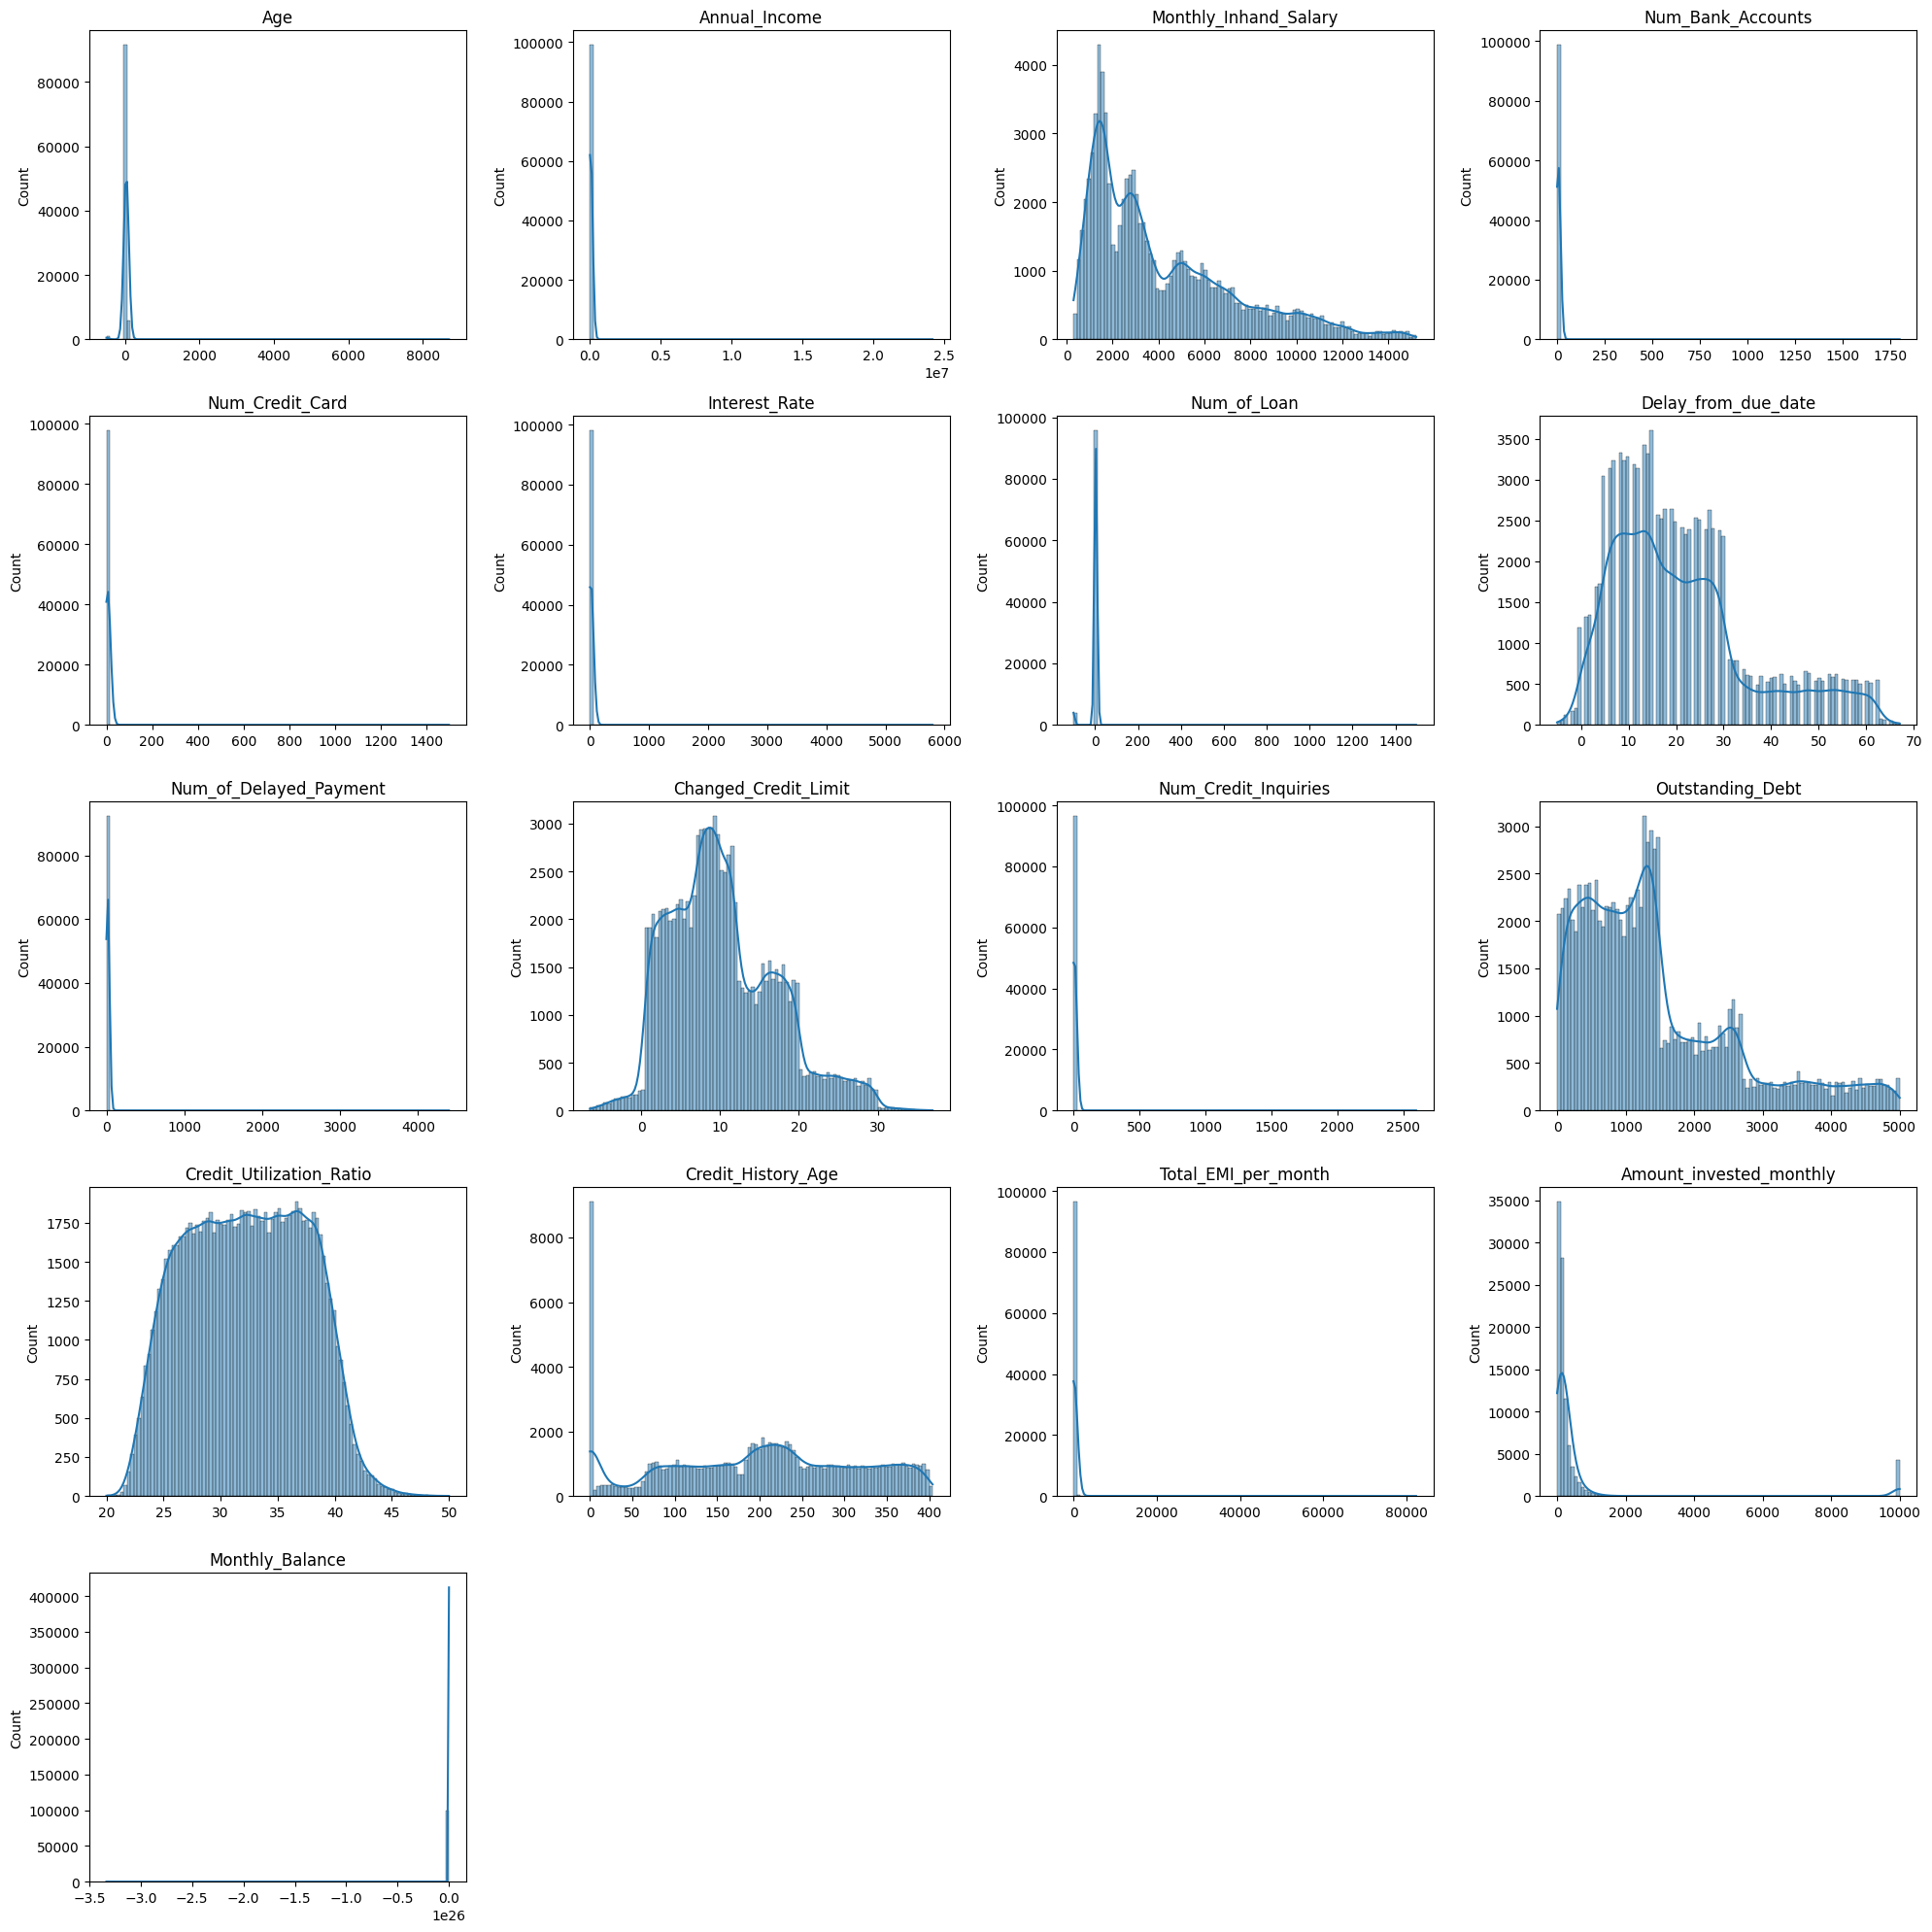

In [ ]:
# Explore the distribution of numeric variables:
def plot_histogram(df, columns, rows=2, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
      if i < len(axes):
        sns.histplot(df[column], kde=True, ax=axes[i], bins=100)
        axes[i].set_title(column)
        axes[i].set_xlabel('')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
plot_histogram(data_train, train_num_col, rows=5, cols=4)

In [ ]:
# Fill with either mean, mode or Unknown category
def fill_with_mean(df, columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].mean())
    return df

data_train = fill_with_mean(data_train, ['Monthly_Inhand_Salary', 'Changed_Credit_Limit', 'Monthly_Balance'])

def fill_with_mode(df, columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].mode())
    return df

data_train = fill_with_mode(data_train, ['Num_of_Delayed_Payment', 'Num_Credit_Inquiries'])

def NaN_to_unknown(df, columns):
    for col in columns:
        df[col] = df[col].fillna('Unknown')
    return df

data_train = NaN_to_unknown(data_train, ['Credit_Mix', 'Occupation'])

# Amount_invested_monthly turn 10000 to mean of 0-2000 and blanks into mean of 0-2000
def AIM(df, column_name='Amount_invested_monthly', target_value=10000, range_min=0, range_max=2000):
    mask = df[column_name].between(range_min, range_max)
    mean_in_range = df.loc[mask, column_name].mean()
    df[column_name] = df[column_name].replace(target_value, mean_in_range)
    df[column_name] = df[column_name].fillna(mean_in_range)
    return df

data_train = AIM(data_train)

# Turn gibberish 'Payment_Behaviour' category to 'Unknown'
def fix_PB(df, column_name='Payment_Behaviour'):
    df[column_name] = df[column_name].replace('98', 'Unknown')
    return df

data_train = fix_PB(data_train)

In [ ]:
# Remove outliers
# Ages beyond 1-100 to mean of 1-100
def fix_age(df):
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    valid = df['Age'].between(1, 100)
    age_mean = df.loc[valid, 'Age'].mean()
    df.loc[~valid, 'Age'] = age_mean
    return df

data_train = fix_age(data_train)

# Columns with outliers beyond 0-100 turn to mode
fixing_yes = ['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries']

def fix_to_mode(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
        valid = df[column].between(0, 100)
        mode_fix = df.loc[valid, column].mode()
        if len(mode_fix):  # mode could be empty
            df.loc[~valid, column] = mode_fix.iloc[0]
        else:
            df.loc[~valid, column] = 0
    return df

data_train = fix_to_mode(data_train, fixing_yes)

# Annual income after 1-500K turn to median
def fix_income(df):
    df['Annual_Income'] = pd.to_numeric(df['Annual_Income'], errors='coerce')
    valid = df['Annual_Income'].between(1, 500000)
    median = df.loc[valid, 'Annual_Income'].median()
    df.loc[~valid, 'Annual_Income'] = median
    return df

data_train = fix_income(data_train)

# Total_EMI_per_month after 1-20K turn to median
def fix_EMI(df):
    df['Total_EMI_per_month'] = pd.to_numeric(df['Total_EMI_per_month'], errors='coerce')
    valid = df['Total_EMI_per_month'].between(1, 20000)
    median = df.loc[valid, 'Total_EMI_per_month'].median()
    df.loc[~valid, 'Total_EMI_per_month'] = median
    return df

data_train = fix_EMI(data_train)

# Monthly balance remove negatives to mean
def fix_MB(df):
    df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce')
    valid = df['Monthly_Balance'] >= 0
    mean = df.loc[valid, 'Monthly_Balance'].mean()
    df.loc[~valid, 'Monthly_Balance'] = mean
    return df

data_train = fix_MB(data_train)

In [ ]:
categorical_cols = data_train.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    num_unique = data_train[col].nunique()
    print(f"{col}: {num_unique} unique categories")

Occupation: 16 unique categories
Credit_Mix: 4 unique categories
Payment_of_Min_Amount: 3 unique categories
Payment_Behaviour: 7 unique categories
Credit_Score: 3 unique categories


In [ ]:
data_train.isnull().sum()

,0
Age,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,0
Num_Bank_Accounts,0
Num_Credit_Card,0
Interest_Rate,0
Num_of_Loan,0
Delay_from_due_date,0
Num_of_Delayed_Payment,0


In [ ]:
data_train.nunique()

,0
Age,47
Occupation,16
Annual_Income,12507
Monthly_Inhand_Salary,13236
Num_Bank_Accounts,60
Num_Credit_Card,79
Interest_Rate,53
Num_of_Loan,38
Delay_from_due_date,68
Num_of_Delayed_Payment,41


In [ ]:
# Categorical non-ordered encoding ('Occupation')
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data_train['Occupation'] = enc.fit_transform(data_train[['Occupation']]).astype('int32')

# Categorical ordered encoding ('Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score')
# Credit_Mix
credit_mix_mapping = {'Unknown': 1, 'Bad': 0, 'Standard': 1, 'Good': 2}
data_train['Credit_Mix'] = data_train['Credit_Mix'].map(credit_mix_mapping)

# Payment_of_Min_Amount
Payment_of_Min_Amount_mapping = {'Yes': 2, 'No': 0, 'NM': 1}
data_train['Payment_of_Min_Amount'] = data_train['Payment_of_Min_Amount'].map(Payment_of_Min_Amount_mapping)

# Credit_Score
credit_score_mapping = {'Good': 2, 'Standard': 1, 'Poor': 0}
y_int = data_train['Credit_Score'].map(credit_score_mapping).astype(int).values  # y defined here

# Payment_Behaviour
Payment_Behaviour_mapping = {'HighspentLargevaluepayments': 5, 'HighspentMediumvaluepayments': 4, 'HighspentSmallvaluepayments': 3,
                             'LowspentLargevaluepayments': 2, 'LowspentMediumvaluepayments': 1, 'LowspentSmallvaluepayments': 0,
                             'Unknown': 0}
data_train['Payment_Behaviour'] = data_train['Payment_Behaviour'].map(Payment_Behaviour_mapping)

In [ ]:
data_train.dtypes

,0
Age,float64
Occupation,int32
Annual_Income,float64
Monthly_Inhand_Salary,float64
Num_Bank_Accounts,float64
Num_Credit_Card,float64
Interest_Rate,float64
Num_of_Loan,float64
Delay_from_due_date,float64
Num_of_Delayed_Payment,float64


In [ ]:
data_train.Credit_Score.value_counts()

,count
Credit_Score,
Standard,53174
Poor,28998
Good,17828


In [ ]:
# Transformer model needs numeric columns first then categorical in the cardinality order
NUMERIC_COLS = train_num_col

CAT_COLS = [          # order MUST match cardinalities
    'Occupation',               # 16
    'Credit_Mix',               # 4
    'Payment_of_Min_Amount',    # 3
    'Payment_Behaviour',        # 7
]
CARDINALITIES = [16, 4, 3, 7]
num_numeric   = len(NUMERIC_COLS)

new_order = NUMERIC_COLS + CAT_COLS
data_train1 = data_train[new_order]
# Global column indices
NUMERIC_IDX = [data_train1.columns.get_loc(c) for c in NUMERIC_COLS]
CAT_IDX = [data_train1.columns.get_loc(c) for c in CAT_COLS]

X = data_train1.astype(np.float32).values  # X defined here
print(NUMERIC_IDX)
print(CAT_COLS)
data_train1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']


,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Occupation,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour
0,-0.971311,-0.815413,-8.072221e-01,-0.817468,-0.537295,-1.303392,0.180580,-1.231192,-1.116043,1.311345e-01,...,-0.533485,-1.067562,0.557894,-0.140373,-0.604018,-0.423564,12,1,0,3
1,-0.971311,-0.815413,-3.098619e-16,-0.817468,-0.537295,-1.303392,0.180580,-0.418102,0.826616,1.311345e-01,...,-0.533485,-0.066489,-1.760158,-0.140373,-0.405353,-0.554591,12,2,0,2
2,0.000000,-0.815413,-3.098619e-16,-0.817468,-0.537295,-1.303392,0.180580,-1.231192,-1.116043,2.644135e-16,...,-0.533485,-0.718376,0.575389,-0.140373,-0.597280,-0.335523,12,2,0,1
3,-0.971311,-0.815413,-3.098619e-16,-0.817468,-0.537295,-1.303392,0.180580,-1.095677,-1.601707,-6.131233e-01,...,-0.533485,-0.177318,0.584136,-0.140373,0.020560,-0.842325,12,2,0,0
4,-0.971311,-0.815413,-8.072221e-01,-0.817468,-0.537295,-1.303392,0.180580,-1.027920,0.826616,1.311345e-01,...,-0.533485,-1.463366,0.592884,-0.140373,-0.808613,-0.287175,12,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.783132,-0.281177,-2.843983e-01,-0.478478,0.136416,-0.846661,-0.584832,0.123958,-1.116043,1.653703e-01,...,-0.799776,0.464817,1.546347,-0.154442,-0.706034,0.363635,9,1,0,5
99996,-0.783132,-0.281177,-2.843983e-01,-0.478478,0.136416,-0.846661,-0.584832,-0.214829,-1.116043,1.653703e-01,...,-0.799776,1.618273,1.555094,-0.154442,-0.741635,0.442552,9,1,0,4
99997,-0.783132,-0.281177,-2.843983e-01,-0.478478,0.136416,-0.732478,-0.584832,0.394988,-1.277931,1.653703e-01,...,-0.799776,1.753100,1.563841,-0.154442,-0.899861,0.537366,9,2,0,5
99998,-0.783132,-0.281177,-2.843983e-01,-0.478478,0.136416,-0.846661,-0.584832,-0.079314,0.826616,1.653703e-01,...,-0.799776,0.264427,1.572589,-0.154442,0.294512,-0.392194,9,2,0,2


In [ ]:
# Prepare the frames
scaler = StandardScaler()
def prepare_frames(X_arr, y_arr=None, fit=False):
    # numeric slice
    X_num = X_arr[:, NUMERIC_IDX].astype('float32')
    if fit:
        scaler.fit(X_num)
    X_num = scaler.transform(X_num)

    # categorical slice
    X_cat = X_arr[:, CAT_IDX]
    if fit:
        enc.fit(X_cat)
    X_cat = enc.transform(X_cat).astype('int32')

    inputs = {'numeric': X_num}
    for i in range(len(CAT_COLS)):
        inputs[f'cat_{i}'] = X_cat[:, i]
    return inputs if y_arr is None else (inputs, y_arr)

In [ ]:
# Transformer Model architecture
class TokenAndPositionEmbedding(layers.Layer):
    """Turn numeric + categorical fields into a sequence of d_model vectors."""
    def __init__(self, num_numeric, cardinalities, d_model):
        super().__init__()
        self.num_numeric = num_numeric
        self.d_model = d_model

        # 1. single dense projection for all numeric fields
        self.dense_num = layers.Dense(d_model, use_bias=False)

        # 2. embedding table for each categorical
        self.cat_embeds = [
            layers.Embedding(c, d_model) for c in cardinalities
        ]

        # 3. learnable positional encoding (one vector per field)
        n_tokens = 1 + len(cardinalities)          # numeric token + categoricals
        self.pos_embed = self.add_weight(
            shape=(1, n_tokens, d_model),
            initializer='random_normal',
            trainable=True,
            name='pos_embed'
        )

    def call(self, inputs):
        num_in, *cat_ins = inputs  # unpack
        # numeric token: (B, d_model)
        x_num = self.dense_num(num_in)[:, None, :]

        # categorical tokens: (B, d_model) each
        x_cats = [emb(cat) for emb, cat in zip(self.cat_embeds, cat_ins)]
        x_cats = [xc[:, None, :] for xc in x_cats]  # add token dimension

        # concat along token axis  -> (B, n_tokens, d_model)
        x = tf.concat([x_num] + x_cats, axis=1)
        x = x + self.pos_embed
        return x


class TransformerBlock(layers.Layer):
    """Pre-norm transformer encoder block (multi-head attention + FF)."""
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads,
                                              key_dim=d_model//num_heads,
                                              dropout=dropout)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='gelu'),
            layers.Dense(d_model)
        ])
        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop = layers.Dropout(dropout)

    def call(self, x, training=None):
        # self-attention with residual
        attn_out = self.attn(x, x, training=training)
        x = self.ln1(x + self.drop(attn_out, training=training))
        # feed-forward with residual
        ffn_out = self.ffn(x)
        x = self.ln2(x + self.drop(ffn_out, training=training))
        return x


def build_tab_transformer(num_numeric, cardinalities, d_model=64, num_heads=4,
                          ff_mult=2, num_blocks=4, dropout=0.1):
    # inputs
    num_in = layers.Input(shape=(num_numeric,), name='numeric')
    cat_ins = [layers.Input(shape=(), dtype='int32', name=f'cat_{i}')
               for i in range(len(cardinalities))]

    # tokenise
    x = TokenAndPositionEmbedding(num_numeric, cardinalities, d_model)([num_in, *cat_ins])

    # stack of transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(d_model, num_heads, int(d_model*ff_mult), dropout)(x)

    # global average pooling + classifier head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(3, activation='softmax', name='prob')(x)  # Output shape

    model = models.Model([num_in] + cat_ins, out)
    return model


===== Fold 1/3 =====
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - Sparse_acc: 0.6013 - loss: 0.8663 - val_Sparse_acc: 0.6684 - val_loss: 0.7418
Epoch 2/30
 17/261 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Sparse_acc: 0.6519 - loss: 0.7726

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: Sparse_acc,loss,val_Sparse_acc,val_loss
  current = self.get_monitor_value(logs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - Sparse_acc: 0.6630 - loss: 0.7452 - val_Sparse_acc: 0.6818 - val_loss: 0.7181
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - Sparse_acc: 0.6756 - loss: 0.7219 - val_Sparse_acc: 0.6930 - val_loss: 0.7062
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Sparse_acc: 0.6811 - loss: 0.7148 - val_Sparse_acc: 0.6904 - val_loss: 0.7024
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Sparse_acc: 0.6821 - loss: 0.7105 - val_Sparse_acc: 0.6949 - val_loss: 0.7016
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Sparse_acc: 0.6875 - loss: 0.7025 - val_Sparse_acc: 0.6960 - val_loss: 0.6993
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - Sparse_acc: 0.6869 - loss: 0.7000 - val_Sparse_acc: 0.6945 - val_loss: 0.7030
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Sparse_acc: 0.6908 - loss: 0.6953 - val_Sparse_acc: 0.6965 - val_loss: 0.6948
Epoch 9/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Sparse_acc: 0.6906 - loss: 0.

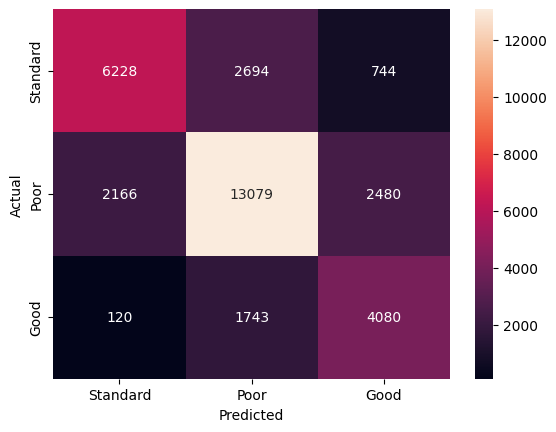


===== Fold 2/3 =====
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - Sparse_acc: 0.6012 - loss: 0.8827 - val_Sparse_acc: 0.6767 - val_loss: 0.7253
Epoch 2/30
 15/261 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Sparse_acc: 0.6532 - loss: 0.7566

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: Sparse_acc,loss,val_Sparse_acc,val_loss
  current = self.get_monitor_value(logs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Sparse_acc: 0.6608 - loss: 0.7463 - val_Sparse_acc: 0.6826 - val_loss: 0.7166
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Sparse_acc: 0.6728 - loss: 0.7240 - val_Sparse_acc: 0.6877 - val_loss: 0.7117
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - Sparse_acc: 0.6790 - loss: 0.7159 - val_Sparse_acc: 0.6869 - val_loss: 0.7075
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - Sparse_acc: 0.6838 - loss: 0.7105 - val_Sparse_acc: 0.6934 - val_loss: 0.7096
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Sparse_acc: 0.6858 - loss: 0.7091 - val_Sparse_acc: 0.6936 - val_loss: 0.6967
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - Sparse_acc: 0.6881 - loss: 0.7027 - val_Sparse_acc: 0.6946 - val_loss: 0.7000
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Sparse_acc: 0.6861 - loss: 0.7012 - val_Sparse_acc: 0.6959 - val_loss: 0.6948
Epoch 9/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - Sparse_acc: 0.6906 - loss: 0.

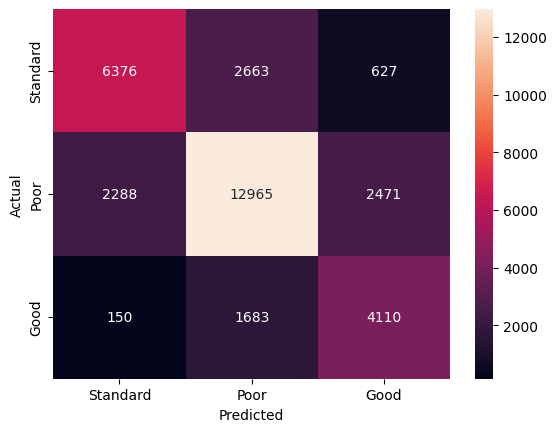


===== Fold 3/3 =====
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - Sparse_acc: 0.6153 - loss: 0.8357 - val_Sparse_acc: 0.6793 - val_loss: 0.7262
Epoch 2/30
 12/261 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - Sparse_acc: 0.6537 - loss: 0.7520

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: Sparse_acc,loss,val_Sparse_acc,val_loss
  current = self.get_monitor_value(logs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Sparse_acc: 0.6652 - loss: 0.7396 - val_Sparse_acc: 0.6880 - val_loss: 0.7158
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - Sparse_acc: 0.6727 - loss: 0.7228 - val_Sparse_acc: 0.6883 - val_loss: 0.7066
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Sparse_acc: 0.6813 - loss: 0.7114 - val_Sparse_acc: 0.6940 - val_loss: 0.7199
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - Sparse_acc: 0.6809 - loss: 0.7112 - val_Sparse_acc: 0.6962 - val_loss: 0.7025
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - Sparse_acc: 0.6864 - loss: 0.7047 - val_Sparse_acc: 0.6970 - val_loss: 0.7094
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Sparse_acc: 0.6875 - loss: 0.7008 - val_Sparse_acc: 0.6947 - val_loss: 0.6991
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - Sparse_acc: 0.6831 - loss: 0.7026 - val_Sparse_acc: 0.6980 - val_loss: 0.6958
Epoch 9/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - Sparse_acc: 0.6898 - loss: 0

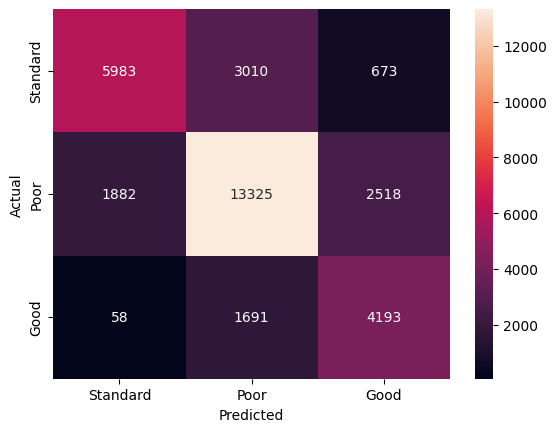


Mean CV AUC: 0.8530 ± 0.0021


In [ ]:
# Hyper parameters + training + test
BATCH_SIZE = 256
EPOCHS     = 20
d_model    = 64
num_heads  = 4
num_blocks = 3
ff_mult    = 2
dropout    = 0.2

# K-Fold cross validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=55)
scores, oof_probs = [], np.zeros((X.shape[0], 3))

# Turn into tensors and batch load
def df_to_dataset(x_dict, y_arr=None, shuffle=False, batch=BATCH_SIZE):
    """Dict of arrays -> tf.data.Dataset"""
    if y_arr is None:
        ds = tf.data.Dataset.from_tensor_slices(x_dict)
    else:
        ds = tf.data.Dataset.from_tensor_slices((x_dict, y_arr))
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_int)):
    print(f'\n===== Fold {fold+1}/3 =====')
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_int[train_idx], y_int[val_idx]   # integers 0/1/2

    # Prepare features (no y passed to prepare_frames)
    X_train_dict = prepare_frames(X_train, fit=(fold==0))
    X_val_dict   = prepare_frames(X_val,   fit=False)

    # Datasets
    train_ds = df_to_dataset(X_train_dict, y_train, shuffle=True)
    val_ds   = df_to_dataset(X_val_dict, y_val, shuffle=False)

    # Build fresh model
    tf.keras.backend.clear_session()
    model = build_tab_transformer(num_numeric=num_numeric,
                                  cardinalities=CARDINALITIES,
                                  d_model=d_model,
                                  num_heads=num_heads,
                                  ff_mult=ff_mult,
                                  num_blocks=num_blocks,
                                  dropout=dropout)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate = 1e-3, weight_decay = 1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='Sparse_acc')])

    # # Class weights
    # class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    # class_weights_dict = dict(enumerate(class_weights))

    # Train
    history = model.fit(train_ds,
                        epochs=EPOCHS,
                        validation_data=val_ds,
                        callbacks=[tf.keras.callbacks.EarlyStopping(
                                      monitor='val_acc', patience=5,
                                      mode='max', restore_best_weights=True)],
                        verbose=1) # class_weight=class_weights_dict,

    '''Predict:'''
    val_prob = model.predict(val_ds)          # Vector of triples with the probs of each class.
    val_pred = np.argmax(val_prob, axis=1)    # Actual classes classification.
    oof_probs[val_idx] = val_prob # ("Out of fold")

    '''Metrics:'''
    # ROC-AUC for 3 classes. strategy: One-vs-Rest. Average: Macro (regular, not weighted)
    fold_auc = roc_auc_score(y_val, val_prob, multi_class='ovr', average='macro')
    scores.append(fold_auc)

    '''Print:'''
    print(f'Fold {fold+1} AUC: {fold_auc:.4f}')
    print("\nClassification Report:")
    print(classification_report(y_val, val_pred, target_names=['Standard', 'Poor', 'Good']))

    '''CONFUSION MATRIX:'''
    cm = confusion_matrix(y_val, val_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Standard','Poor','Good'],
                yticklabels=['Standard','Poor','Good'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print(f'\nMean CV AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}')

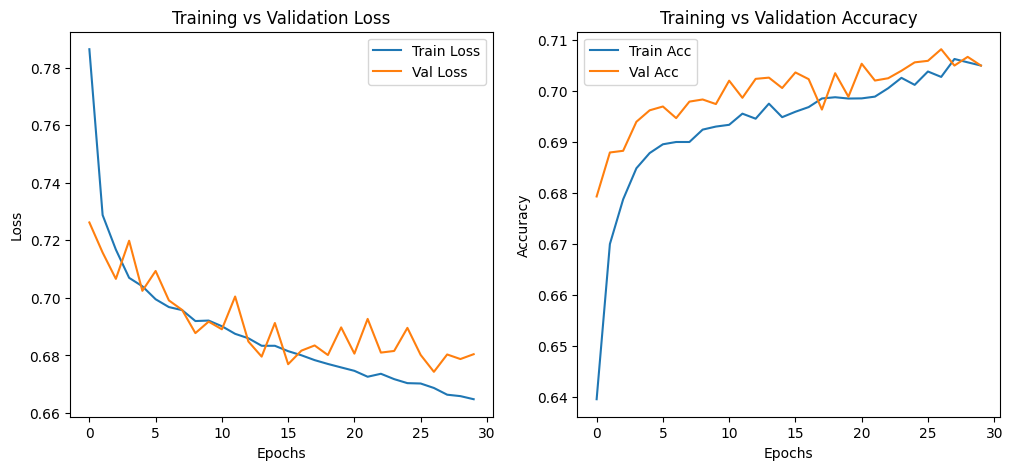

In [ ]:
# Plot entrenamiento vs validación
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0.66, 1)
plt.legend()
plt.title('Training vs Validation Loss')

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['Sparse_acc'], label='Train Acc')
plt.plot(history.history['val_Sparse_acc'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.ylim(0, 1)
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.show()

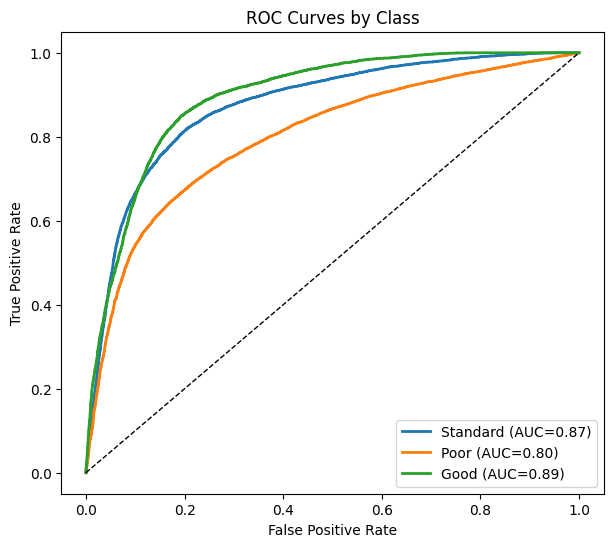

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Convertir y_val a one-hot para ROC
y_val_bin = label_binarize(y_val, classes=[0,1,2])

plt.figure(figsize=(7,6))
for i, class_name in enumerate(['Standard','Poor','Good']):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], val_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend()
plt.show()

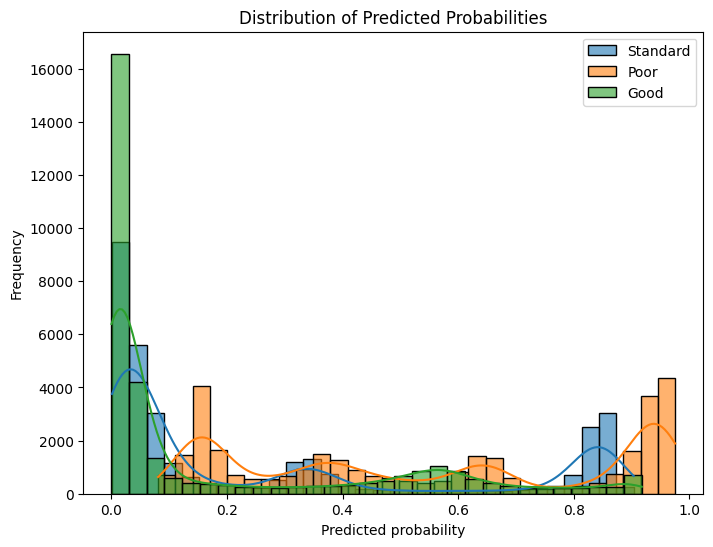

In [ ]:
plt.figure(figsize=(8,6))
for i, class_name in enumerate(['Standard','Poor','Good']):
    sns.histplot(val_prob[:, i], bins=30, kde=True, label=class_name, alpha=0.6)

plt.xlabel('Predicted probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()

#Conclusion
EmbedMLP achieved the best results, outperforming traditional ML, RNN, and Transformer
models with a balanced performance across all credit classes.32
Transformer models were not ideal for tabular data due to their architecture, which expects
sequential or contextual relationships. They suffered from overfitting and unstable training
despite tuning.
RNN and LSTM architectures showed moderate success but were less effective for static
tabular data compared to feedforward approaches.
Traditional ML models (Logistic Regression, Decision Tree, SVM) underperformed,
highlighting the advantages of deep learning for complex, nonlinear credit data.
Data preprocessing (handling missing values, encoding categorical variables, and scaling
numeric features) was critical to model stability and accuracy.
Future improvements could focus on:
Feature engineering for the “Standard” credit class (where misclassification persisted),
Using hybrid architectures combining embeddings with attention,
Exploring ensemble approaches or explainable AI techniques for model transparency in
credit risk assessment.